
<h1 style="text-align: center;">Trabajo Práctico Nº 2</h1>

In [1]:
import cv2
import matplotlib.pyplot as plt
import os 
import numpy as np
from skimage import data, util, img_as_float
from skimage.util import random_noise
from skimage.restoration import denoise_bilateral, denoise_tv_chambolle

# Ejercicio 1

### Cálculo de índices espectrales: NDVI, NDWI y SVI

### Selección de las imágenes satelitales utilizadas

Para el análisis de los índices espectrales (NDVI, NDWI y SVI), se trabajó con imágenes satelitales ópticas correspondientes a la ciudad de **Rada Tilly**, ubicada en la provincia de **Chubut, Argentina**.

Las imágenes fueron obtenidas en USGS Earth Explorer. Para ello, se realizó una búsqueda geográfica centrada en Rada Tilly utilizando la herramienta de ubicación del sitio, y se seleccionó una escena correspondiente a la **misión Landsat 8**, dentro del conjunto de datos **"Landsat Collection 2 Level-1"**. Este conjunto proporciona imágenes en alta resolución espacial con las bandas espectrales necesarias para el cálculo de los índices requeridos.

Se utilizó una escena correspondiente al **path 228 y row 092**, capturada el día **4 de enero de 2025**, lo cual permite observar la superficie terrestre en época estival, favoreciendo la identificación de vegetación activa, áreas urbanas y posibles cuerpos de agua o zonas húmedas.

Esta zona de la Patagonia argentina presenta un entorno semiárido costero, con escasa vegetación y predominancia de suelos descubiertos, lo cual ofrece un caso interesante para analizar la sensibilidad de cada índice frente a las condiciones naturales del terreno.

Cabe destacar que a las imágenes se las transformo a 8bits, dado su peso original (80mb) que lo hacia imposible subir a GitHub.
Las bandas utilizadas para el cálculo de los índices fueron extraídas individualmente del paquete de producto descargado, en formato GeoTIFF, y corresponden a:

- **B3 (Green)**
- **B4 (Red)**
- **B5 (Near Infrared - NIR)**

Estas bandas fueron seleccionadas por ser las adecuadas para los cálculos de NDVI, NDWI y SVI, según la bibliografía cuyo calculo son los siguientes:

- **NDVI (Índice de Vegetación de Diferencia Normalizada)**:  
  $$ \text{NDVI} = \frac{\text{NIR} - \text{Red}}{\text{NIR} + \text{Red}} $$
  Este índice permite detectar vegetación activa, aprovechando el alto nivel de reflectancia del infrarrojo cercano (NIR) y la baja reflectancia en el rojo visible por parte de la vegetación.


- **NDWI (Índice Diferencial de Agua Normalizado)**:  
  $$ \text{NDWI} = \frac{\text{Green} - \text{NIR}}{\text{Green} + \text{NIR}} $$
  Se utiliza para detectar cuerpos de agua o humedad en el suelo y vegetación.

- **SVI (Índice Simple de Vegetación)**:  
  $$ \text{SVI} = \frac{\text{NIR}}{\text{Red}} $$
  A diferencia del NDVI, este índice no normaliza por la suma de bandas y es más sensible a la variación relativa entre el NIR y el rojo.

---

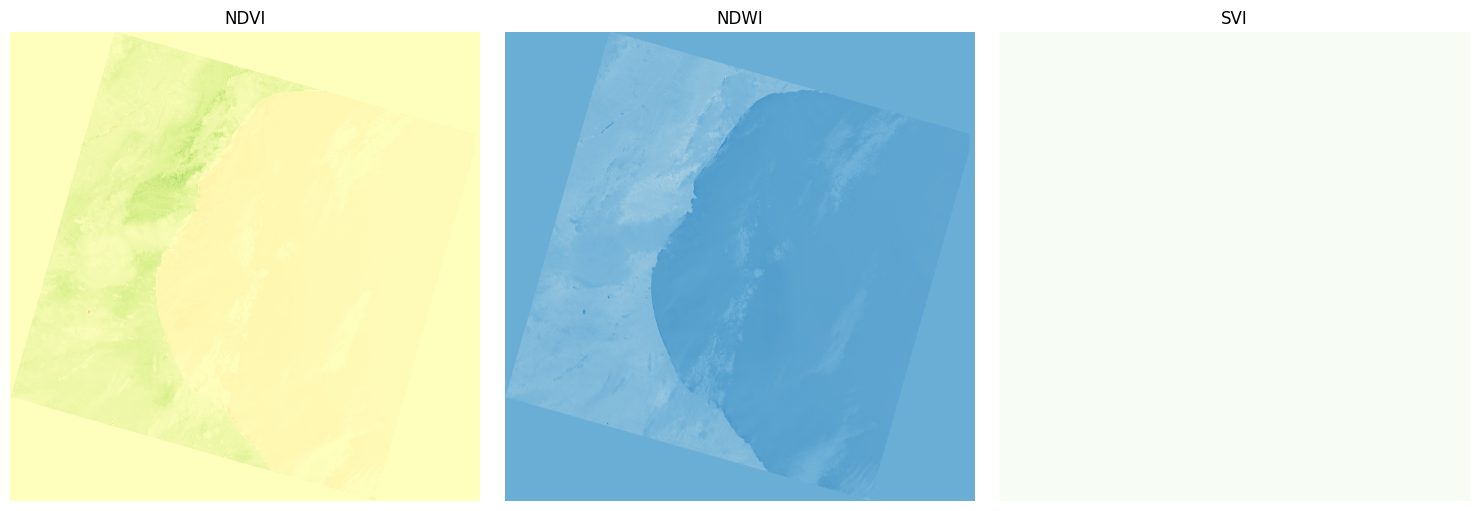

In [53]:
# Funciones para calcular los índices
def calculate_ndvi(nir_band, red_band):
    ndvi = (nir_band - red_band) / (nir_band + red_band + 1e-10)
    return ndvi

def calculate_ndwi(nir_band, green_band):
    ndwi = (green_band - nir_band) / (green_band + nir_band + 1e-10)
    return ndwi

def calculate_svi(nir_band, red_band):
    return nir_band / (red_band + 1e-10)

# Cargar las bandas necesarias

red_band = cv2.imread('rada_tilly/B4_8bit.tif', cv2.IMREAD_GRAYSCALE)
nir_band = cv2.imread('rada_tilly/B5_8bit.tif', cv2.IMREAD_GRAYSCALE)
green_band = cv2.imread('rada_tilly/B3_8bit.tif', cv2.IMREAD_GRAYSCALE)

# Asegurarse de que las bandas tengan el mismo tamaño
if red_band.shape != nir_band.shape or red_band.shape != green_band.shape:
    raise ValueError("Las bandas deben tener el mismo tamaño.")

# Calcular los índices
ndvi = calculate_ndvi(nir_band.astype(float), red_band.astype(float))
ndwi = calculate_ndwi(nir_band.astype(float), green_band.astype(float))
svi = calculate_svi(nir_band, red_band)

# Mostrar los índices como imágenes
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(ndvi, cmap='RdYlGn')
axes[0].set_title('NDVI')
axes[0].axis('off')

axes[1].imshow(ndwi, cmap='Blues')
axes[1].set_title('NDWI')
axes[1].axis('off')

axes[2].imshow(svi, cmap='Greens')
axes[2].set_title('SVI')
axes[2].axis('off')

plt.tight_layout()
plt.show()

### Resultados

- **NDVI**:  
  La imagen resultante muestra una variación tonal coherente con las áreas vegetadas (en tonos verdes) y zonas áridas o urbanizadas (en tonos más cercanos al rojo o marrón, o incluso verde muy claro), como se espera en regiones semiáridas como la Patagonia.

- **NDWI**:  
  Se observan zonas con posible humedad (en tonos claros) y zonas secas (en tonos oscuros). Se identifican grandes cuerpos de agua, lo cual es consistente con la geografía del área analizada teniendo en cuenta que la mitad de la imagen se encuentra el océano atlántico. 

- **SVI**:  
  La imagen resultante aparece completamente blanca. Esto se debe a que el índice SVI, al no estar normalizado, genera valores numéricos extremadamente altos en píxeles donde la banda roja presenta valores cercanos a cero. Como resultado, el contraste entre valores es tan grande que los valores bajos se vuelven invisibles al ojo humano en la visualización, y toda la imagen se satura en blanco.  
  A pesar de ello, el índice fue correctamente calculado y puede ser útil para análisis cuantitativos si se aplica un recorte de valores extremos o una escala logarítmica. En este trabajo se decidió conservarlo en su forma directa y justificar el fenómeno observado.


# Ejercicio 2

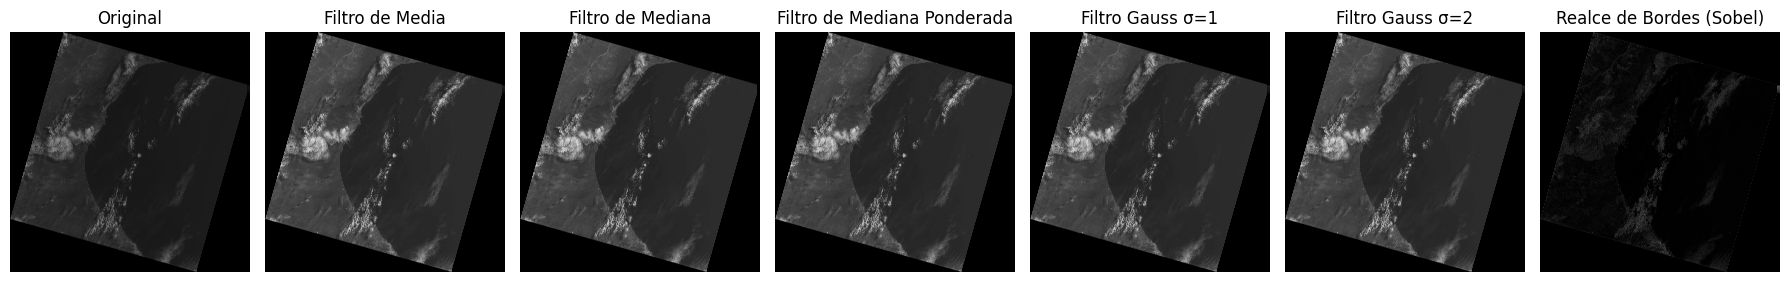

In [5]:
# Cargar la imagen en escala de grises
image_path = 'rada_tilly/B4_8bit.tif'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Función para aplicar filtros
def apply_filters(img, window_size):
    results = {}

    # a) Suavizado con el filtro de la media
    mean_filter = cv2.blur(img, (window_size, window_size))
    results['Filtro de Media'] = mean_filter

    # b) Suavizado con el filtro de la mediana
    median_filter = cv2.medianBlur(img, window_size)
    results['Filtro de Mediana'] = median_filter

    # c) Suavizado con el filtro de la mediana ponderada de 3x3 (optimizado)
    def weighted_median_filter(img, weight_matrix):
        # Agrega un borde de 1 píxel alrededor de la imagen usando reflexión,
        # para poder calcular la vecindad 3x3 incluso en los bordes.
        img_padded = cv2.copyMakeBorder(img, 1, 1, 1, 1, cv2.BORDER_REFLECT)

        # Crea una imagen de salida con las mismas dimensiones que la imagen original
        output = np.zeros_like(img)

        # Recorre todos los píxeles de la imagen original
        for i in range(1, img.shape[0] + 1):        # de 1 a alto+1 (por el borde agregado)
            for j in range(1, img.shape[1] + 1):    # de 1 a ancho+1

                # Extrae la vecindad 3x3 centrada en el píxel actual
                region = img_padded[i-1:i+2, j-1:j+2]

                # Aplana la vecindad en un vector de 9 elementos
                region_flat = region.flatten()

                # Aplana la máscara de pesos en otro vector de 9 elementos
                weights_flat = weight_matrix.flatten()

                # Repite los valores de la vecindad según los pesos correspondientes
                # Por ejemplo, si un valor tiene peso 4, se repite 4 veces
                repeated_values = np.repeat(region_flat, weights_flat.astype(int))

                # Calcula la mediana de todos los valores repetidos
                median_value = np.median(repeated_values)

                # Asigna ese valor al píxel correspondiente en la imagen de salida
                output[i-1, j-1] = median_value

        # Devuelve la imagen filtrada con la mediana ponderada
        return output

    weighted_median_kernel = np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]])
    weighted_median = weighted_median_filter(img, weighted_median_kernel)
    results['Filtro de Mediana Ponderada'] = weighted_median

    # d) Suavizado con el filtro de Gauss para diferentes valores de σ y μ = 0
    gaussian_sigma1 = cv2.GaussianBlur(img, (window_size, window_size), sigmaX=1)
    gaussian_sigma2 = cv2.GaussianBlur(img, (window_size, window_size), sigmaX=2)
    results['Filtro Gauss σ=1'] = gaussian_sigma1
    results['Filtro Gauss σ=2'] = gaussian_sigma2

    # e) Realce de Bordes (Filtro de Sobel)
    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    edges = cv2.magnitude(sobel_x, sobel_y)
    results['Realce de Bordes (Sobel)'] = np.uint8(edges)

    return results

# Tamaño de la ventana deslizante
window_size = 5  # Puedes ajustar el tamaño aquí

# Aplicar filtros y mostrar resultados
filtered_images = apply_filters(image, window_size)

# Visualización de los resultados
fig, axes = plt.subplots(1, len(filtered_images) + 1, figsize=(18, 5))
axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')

# Mostrar cada imagen filtrada
for i, (title, img) in enumerate(filtered_images.items()):
    axes[i+1].imshow(img, cmap='gray')
    axes[i+1].set_title(title)
    axes[i+1].axis('off')

plt.tight_layout()
plt.show()


### Análisis visual de los filtros aplicados

A partir de la imagen correspondiente a la banda roja (B4) de la escena Landsat 8, se aplicaron diferentes técnicas de filtrado mediante una ventana deslizante de tamaño 5×5.

Los filtros utilizados fueron:

- Filtro de la media  
- Filtro de la mediana  
- Filtro de la mediana ponderada 3×3 (implementación manual basada en repetición según máscara de pesos)  
- Filtro Gaussiano (σ = 1 y σ = 2)  
- Realce de bordes con Sobel  

Al analizar visualmente los resultados, se observa que **las diferencias entre las imágenes filtradas son mínimas**. Esto puede deberse a que:

1. La imagen original ya posee **poco ruido** y no contiene detalles de alta frecuencia marcados.  
2. El tamaño de la ventana (5×5) y los parámetros utilizados no generan cambios suficientemente agresivos como para producir diferencias notorias en una imagen suave.  
3. Todos los filtros de suavizado tienden a preservar las estructuras principales cuando la imagen no presenta ruido elevado.  

En cuanto al filtro de **mediana ponderada**, se utilizó una matriz de pesos que asigna mayor importancia al píxel central y a sus vecinos inmediatos. Esta técnica permite **preservar bordes** mejor que un filtro de media, al mismo tiempo que reduce ruido aislado. Sin embargo, en esta imagen en particular, los resultados visuales son similares a los del filtro de mediana simple, debido a la **falta de ruido significativo**.

Respecto al filtro de Sobel, si bien permite detectar bordes, el resultado presenta un contraste bajo, lo cual dificulta la observación clara de los contornos. Esto puede deberse a que los gradientes locales no presentan transiciones abruptas y se requeriría **una normalización** posterior para realzar la visualización.



# Ejercicio 3

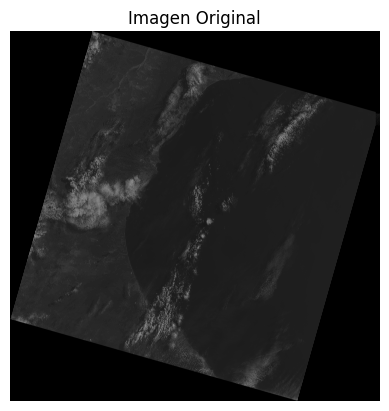

In [55]:
# Cargar la imagen en escala de grises
imagen = cv2.imread('rada_tilly/B3_8bit.tif', cv2.IMREAD_GRAYSCALE)

# Verificar si la imagen se cargó correctamente
if imagen is None:
    raise ValueError("No se pudo cargar la imagen. Verifica la ruta.")

# Aplicar el operador de Prewitt
# Crear kernels de Prewitt para la dirección x y la dirección y
kernel_prewitt_x = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])
kernel_prewitt_y = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])

prewitt_x = cv2.filter2D(imagen, -1, kernel_prewitt_x)
prewitt_y = cv2.filter2D(imagen, -1, kernel_prewitt_y)
prewitt = cv2.addWeighted(prewitt_x, 0.5, prewitt_y, 0.5, 0)
# Aplicar el operador de Sobel
sobel_x = cv2.Sobel(imagen, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(imagen, cv2.CV_64F, 0, 1, ksize=3)
sobel = cv2.addWeighted(np.abs(sobel_x), 0.5, np.abs(sobel_y), 0.5, 0)
plt.imshow(imagen, cmap='gray')
plt.title('Imagen Original')
plt.axis('off')
plt.show()

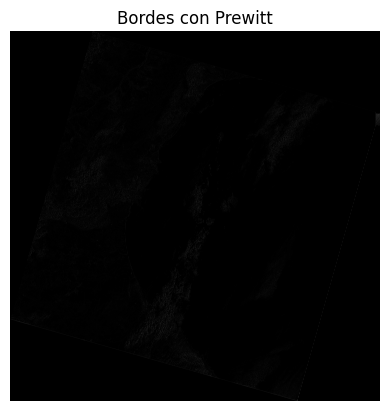

In [56]:
# Bordes con Prewitt
plt.imshow(prewitt, cmap='gray')
plt.title('Bordes con Prewitt')
plt.axis('off')
plt.show()

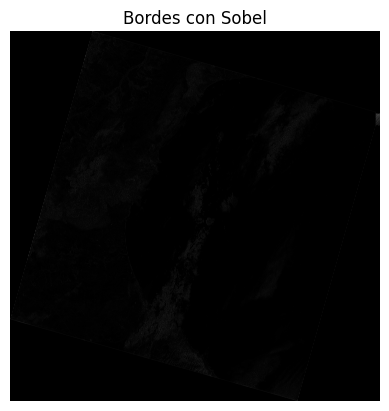

In [57]:
# Bordes con Sobel
plt.imshow(sobel, cmap='gray')
plt.title('Bordes con Sobel')
plt.axis('off')
plt.show()

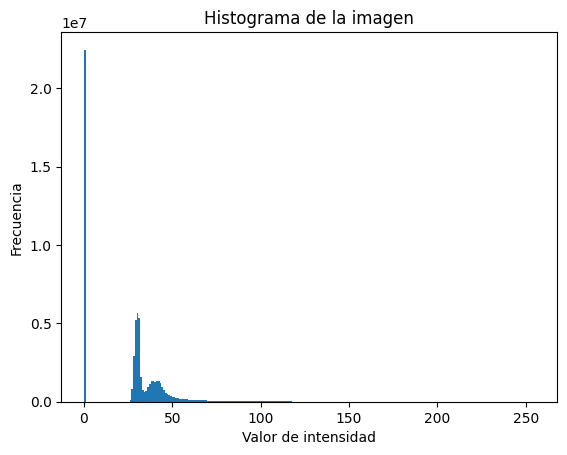

In [58]:
plt.hist(imagen.ravel(), bins=256)
plt.title("Histograma de la imagen")
plt.xlabel("Valor de intensidad")
plt.ylabel("Frecuencia")
plt.show()

### Análisis del contraste de la imagen y cambio de fuente

Inicialmente se intentó aplicar los detectores de bordes de **Prewitt** y **Sobel** sobre la imagen correspondiente a la **banda verde (B3)** de la escena Landsat 8 de la ciudad de **Rada Tilly**. Se probo tambien con la B4 y B5

Para evaluar si la imagen era adecuada para este tipo de análisis, se realizó un histograma de niveles de intensidad. Se observó que **la mayoría de los valores se encontraban concentrados entre 25 y 50**, lo que indica un **bajo contraste general** en la imagen.

Este bajo contraste tiene un impacto directo en la efectividad de los detectores de bordes por gradiente, ya que estos operadores se basan en la detección de diferencias de intensidad entre píxeles vecinos. Como resultado, las imágenes obtenidas tras aplicar los operadores de Prewitt y Sobel se veían oscuras y con escasa visibilidad de contornos.

#### Decisión metodológica

Debido a esta limitación, se decidió **utilizar las imágenes de la ciudad de Bariloche empleadas en el Trabajo Práctico 1**, las cuales presentaban mayor contraste y permitían visualizar de forma clara los contornos obtenidos con los operadores de gradiente. Esta decisión se tomó con el objetivo de garantizar una mejor interpretación visual de los resultados, sin alterar la validez del método.



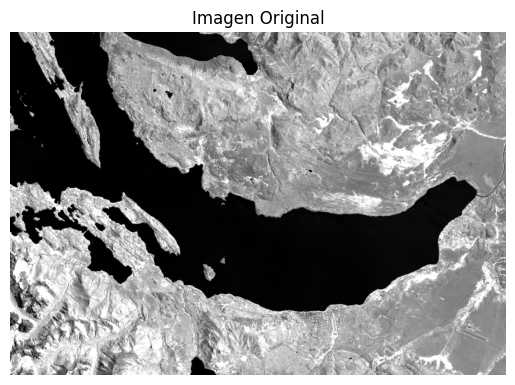

In [59]:
# Cargar la imagen en escala de grises
imagen = cv2.imread('imagenesbariloche/img5.tif', cv2.IMREAD_GRAYSCALE)

# Verificar si la imagen se cargó correctamente
if imagen is None:
    raise ValueError("No se pudo cargar la imagen. Verifica la ruta.")

# Aplicar el operador de Prewitt
# Crear kernels de Prewitt para la dirección x y la dirección y
kernel_prewitt_x = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])
kernel_prewitt_y = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])

prewitt_x = cv2.filter2D(imagen, -1, kernel_prewitt_x)
prewitt_y = cv2.filter2D(imagen, -1, kernel_prewitt_y)
prewitt = cv2.addWeighted(prewitt_x, 0.5, prewitt_y, 0.5, 0)
# Aplicar el operador de Sobel
sobel_x = cv2.Sobel(imagen, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(imagen, cv2.CV_64F, 0, 1, ksize=3)
sobel = cv2.addWeighted(np.abs(sobel_x), 0.5, np.abs(sobel_y), 0.5, 0)
plt.imshow(imagen, cmap='gray')
plt.title('Imagen Original')
plt.axis('off')
plt.show()

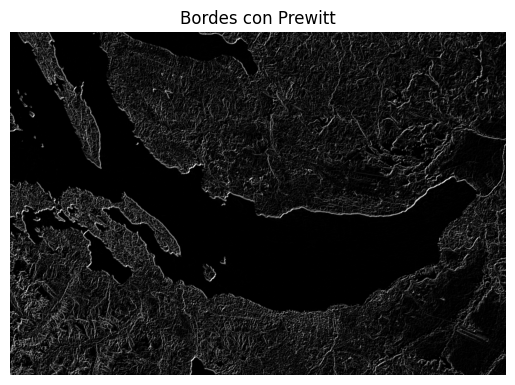

In [60]:
# Bordes con Prewitt
plt.imshow(prewitt, cmap='gray')
plt.title('Bordes con Prewitt')
plt.axis('off')
plt.show()

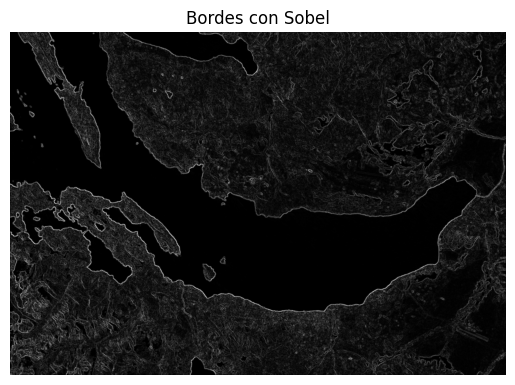

In [61]:
# Bordes con Sobel
plt.imshow(sobel, cmap='gray')
plt.title('Bordes con Sobel')
plt.axis('off')
plt.show()

En este caso, para la img 5 de Bariloche, tanto los bordes con Sobel como con Prewitt, se identifican mucho mas claramente que las imágenes de rada tilly utilzadas anteriormente. 

# Ejercicio 4


Para este punto del trabajo, se busca analizar el comportamiento de distintos operadores de detección de bordes (Laplaciano y sus variantes) frente a distintas condiciones de ruido. 

Dado que las imágenes satelitales utilizadas en los puntos anteriores presentan bajo contraste y estructuras difusas, se optó por utilizar una imagen no satelital con bordes bien definidos para facilitar la visualización y comparación de resultados. Para ello, vamos a utilizar una imagen (cameraman) de la libreria skimage.


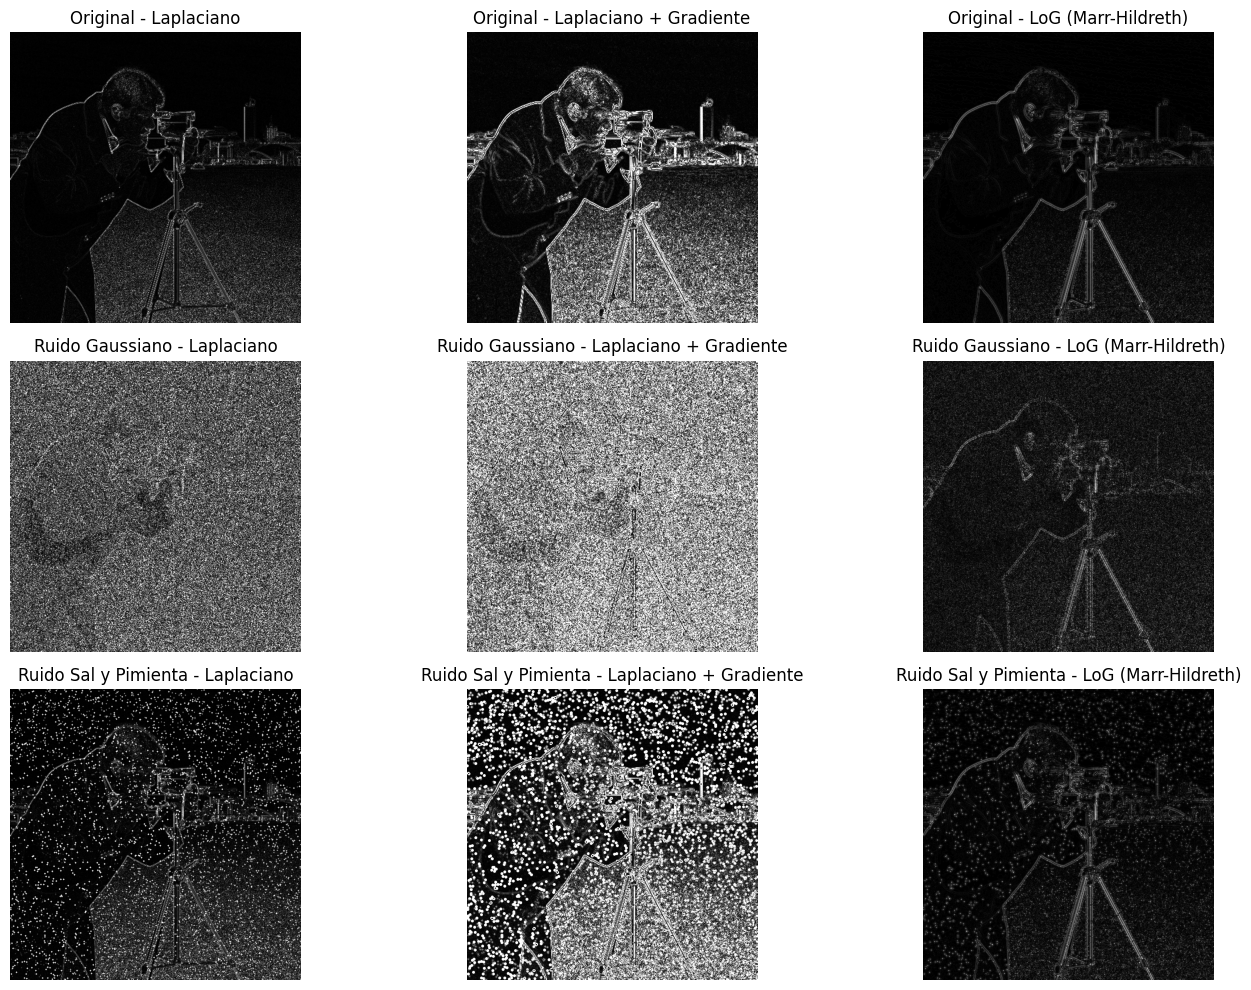

In [62]:
# 1. Cargar imagen de prueba ('cameraman')
# -------------------------
img = data.camera()
img = img.astype(np.uint8)

# -------------------------
# 2. Funciones para agregar ruido
# -------------------------

# a) Ruido gaussiano
def add_gaussian_noise(image, mean=0, std=25):
    noise = np.random.normal(mean, std, image.shape).astype(np.float32)
    noisy = np.clip(image.astype(np.float32) + noise, 0, 255).astype(np.uint8)
    return noisy

# b) Ruido sal y pimienta
def add_salt_pepper_noise(image, prob=0.02):
    noisy = image.copy()
    salt = np.random.rand(*image.shape) < prob / 2
    pepper = np.random.rand(*image.shape) < prob / 2
    noisy[salt] = 255
    noisy[pepper] = 0
    return noisy

# -------------------------
# 3. Aplicar detectores de bordes
# -------------------------

def apply_laplacian_variants(image):
    results = {}

    # a) Laplaciano
    laplacian = cv2.Laplacian(image, cv2.CV_64F)
    laplacian = cv2.convertScaleAbs(laplacian)
    results['Laplaciano'] = laplacian

    # b) Laplaciano con evaluación de pendiente
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    grad_magnitude = cv2.magnitude(sobel_x, sobel_y)
    grad_magnitude = cv2.convertScaleAbs(grad_magnitude)
    lap_grad = cv2.Laplacian(grad_magnitude, cv2.CV_64F)
    lap_grad = cv2.convertScaleAbs(lap_grad)
    results['Laplaciano + Gradiente'] = lap_grad

    # c) Laplaciano del Gaussiano (LoG)
    blurred = cv2.GaussianBlur(image, (5, 5), 1.0)
    lap_of_gauss = cv2.Laplacian(blurred, cv2.CV_64F)
    lap_of_gauss = cv2.convertScaleAbs(lap_of_gauss)
    results['LoG (Marr-Hildreth)'] = lap_of_gauss

    return results

# -------------------------
# 4. Generar versiones ruidosas
# -------------------------
img_gauss_noise = add_gaussian_noise(img)
img_sp_noise = add_salt_pepper_noise(img)

# -------------------------
# 5. Aplicar filtros
# -------------------------
original_results = apply_laplacian_variants(img)
gauss_results = apply_laplacian_variants(img_gauss_noise)
sp_results = apply_laplacian_variants(img_sp_noise)

# -------------------------
# 6. Mostrar resultados
# -------------------------
titles = ['Original', 'Ruido Gaussiano', 'Ruido Sal y Pimienta']
results = [original_results, gauss_results, sp_results]

fig, axes = plt.subplots(len(results), 3, figsize=(15, 10))

for i, res_dict in enumerate(results):
    for j, (title, img_filtered) in enumerate(res_dict.items()):
        axes[i, j].imshow(img_filtered, cmap='gray')
        axes[i, j].set_title(f"{titles[i]} - {title}")
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()


###  Detección de bordes mediante operadores Laplacianos

En este apartado se explora el uso de operadores de segunda derivada, específicamente variantes del operador **Laplaciano**, para la detección de bordes en imágenes.

Se aplicaron tres variantes principales:

1. **Laplaciano simple**: detecta cambios abruptos en la intensidad de la imagen, sin considerar la dirección del borde.
2. **Laplaciano sobre la magnitud del gradiente**: primero se calcula la magnitud del gradiente (combinando Sobel en x e y), y luego se aplica el Laplaciano. Esto permite detectar zonas de fuerte pendiente con mayor precisión.
3. **Laplaciano del Gaussiano (LoG)**: también conocido como operador de **Marr-Hildreth**, consiste en suavizar la imagen mediante un filtro gaussiano para reducir el ruido y luego aplicar el Laplaciano. Es especialmente útil cuando se trabaja con imágenes ruidosas.

---

### Selección de la imagen

Para este análisis no se utilizó una imagen satelital, sino una imagen de prueba estándar conocida como **"Cameraman"**, ampliamente utilizada en el procesamiento digital de imágenes por su nivel de detalle y contrastes definidos. Esta imagen permite observar claramente el efecto de los detectores de bordes, incluso en presencia de ruido, algo que no era tan evidente en las imágenes satelitales utilizadas previamente.

---

### Conclusión

Los resultados obtenidos muestran que:

- El **Laplaciano simple** responde de manera intensa a los bordes, pero también amplifica el ruido, generando contornos no deseados, especialmente en imágenes con ruido.
- El **Laplaciano sobre el gradiente** mejora la detección de bordes relevantes y reduce parcialmente los efectos del ruido, ya que opera sobre zonas con fuerte cambio de intensidad.
- El **Laplaciano del Gaussiano (LoG)** ofrece el mejor equilibrio: suaviza la imagen antes de detectar los bordes, lo que se traduce en una detección más limpia y menos afectada por el ruido. Es especialmente efectivo en la versión con ruido sal y pimienta.

Este análisis permite comparar la robustez de los distintos operadores y su adecuación frente a distintos tipos de ruido, lo cual es clave para su aplicación en imágenes reales.


# Ejercicio 5

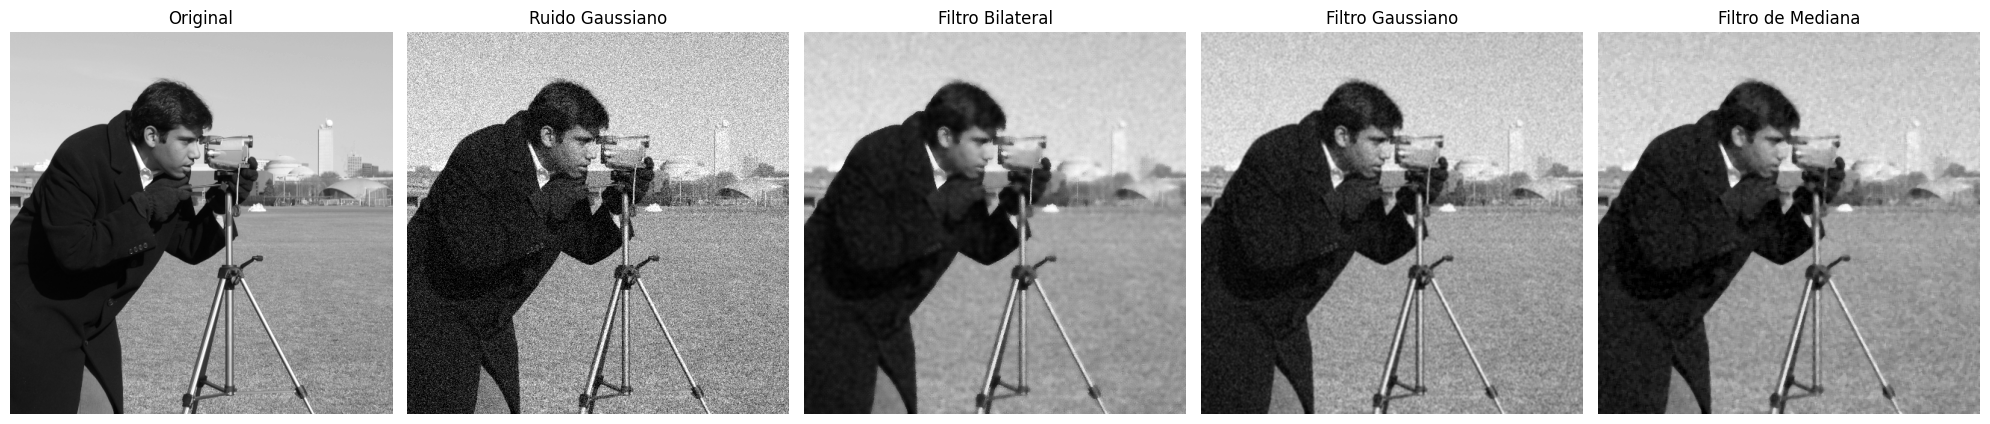

In [63]:
# Cargar imagen original (cameraman)
original = data.camera()

# Agregar ruido gaussiano a la imagen
noisy = util.random_noise(original, mode='gaussian', var=0.01)
noisy = np.array(255 * noisy, dtype=np.uint8)

# Aplicar filtros

# 1. Filtro bilateral
bilateral_filtered = cv2.bilateralFilter(noisy, d=9, sigmaColor=75, sigmaSpace=75)

# 2. Filtro de Gauss
gaussian_filtered = cv2.GaussianBlur(noisy, (5, 5), sigmaX=1)

# 3. Filtro de Mediana
median_filtered = cv2.medianBlur(noisy, 5)

# Visualización de resultados
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
axes[0].imshow(original, cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(noisy, cmap='gray')
axes[1].set_title('Ruido Gaussiano')
axes[1].axis('off')

axes[2].imshow(bilateral_filtered, cmap='gray')
axes[2].set_title('Filtro Bilateral')
axes[2].axis('off')

axes[3].imshow(gaussian_filtered, cmap='gray')
axes[3].set_title('Filtro Gaussiano')
axes[3].axis('off')

axes[4].imshow(median_filtered, cmap='gray')
axes[4].set_title('Filtro de Mediana')
axes[4].axis('off')

plt.tight_layout()
plt.show()



En este punto se implementó el **filtro bilateral** y se lo comparó con el **filtro de Gauss** y el **filtro de la mediana**, aplicándolos sobre una imagen contaminada con **ruido gaussiano** (varianza 0.01). Seguimos utilizando para este punto la imagen de prueba del `cameraman`.

#### Descripción de los filtros aplicados:

- **Filtro bilateral**: suaviza teniendo en cuenta tanto la distancia espacial como la diferencia de intensidad entre píxeles. Su objetivo es reducir el ruido manteniendo los bordes.
- **Filtro de Gauss**: aplica una convolución con un kernel gaussiano. Suaviza de manera uniforme toda la imagen, sin distinguir entre regiones homogéneas y bordes.
- **Filtro de mediana**: reemplaza cada píxel por la mediana de su vecindad. Es especialmente útil para eliminar ruido impulsivo como el de tipo "sal y pimienta".

#### Análisis de resultados:

- El **filtro bilateral** logró reducir el ruido (los puntos generados por la contaminación), pero produjo una imagen **visiblemente desenfocada**, perdiendo nitidez general.
- El **filtro gaussiano** suavizó levemente el ruido pero **conservó mayor enfoque** respecto al bilateral, aunque aún quedaron varios puntos de ruido visibles.
- El **filtro de la mediana** no logró eliminar todo el ruido, pero resultó ser el que **mejor conservó el enfoque** general de la imagen, manteniendo detalles y bordes de forma más definida que los otros dos.

#### Conclusión

En este caso particular, el **filtro de la mediana** resultó el más equilibrado: si bien no eliminó por completo el ruido, mantuvo un buen nivel de detalle en la imagen. El **filtro bilateral**, a pesar de ser teóricamente adecuado para preservar bordes, resultó ser el más **desenfocado visualmente**. El **filtro de Gauss**, por su parte, dejó bastante ruido y mostró un desenfoque intermedio.


# Ejercicio 6

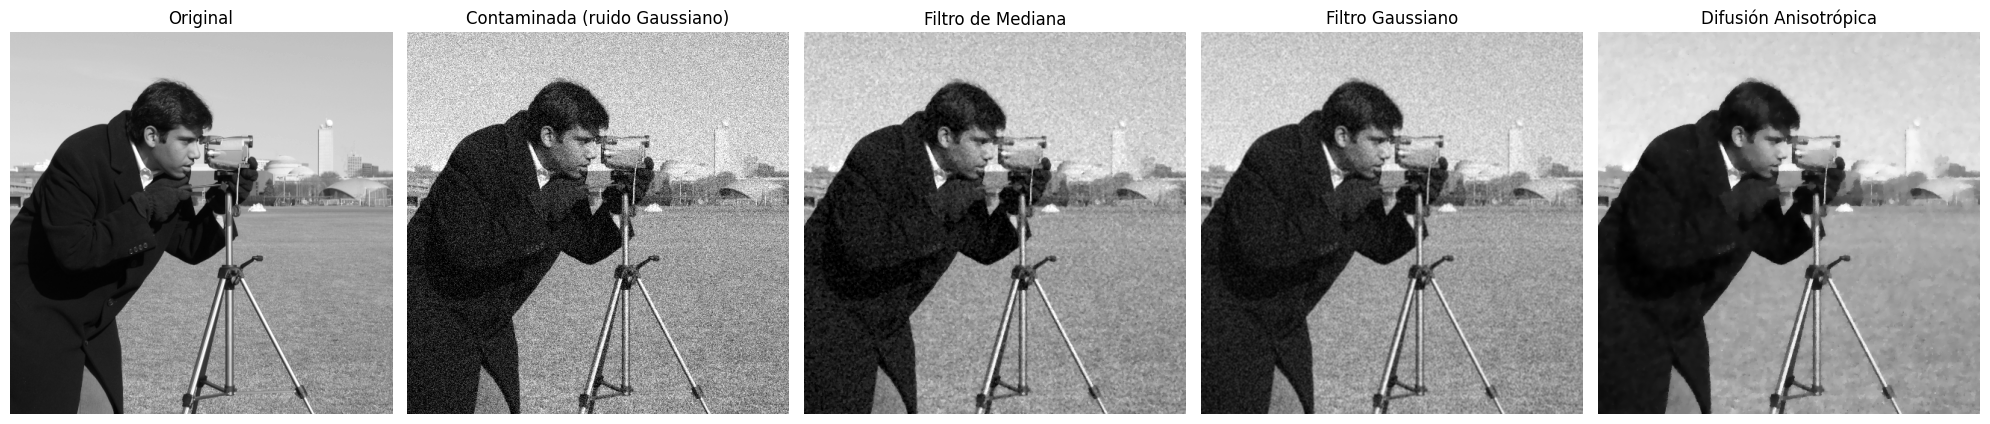

In [64]:
# Cargar la imagen base
image = img_as_float(data.camera())

# Contaminar la imagen con ruido gaussiano
noisy_image = random_noise(image, mode='gaussian', var=0.01)

# Aplicar filtro de mediana
median_filtered = cv2.medianBlur((noisy_image * 255).astype(np.uint8), 3)

# Aplicar filtro gaussiano
gaussian_filtered = cv2.GaussianBlur(noisy_image, (3, 3), sigmaX=1)

# Aplicar difusión anisotrópica (Total Variation Denoising - aproxima Perona-Malik)
anisotropic_filtered = denoise_tv_chambolle(noisy_image, weight=0.1, channel_axis=None)


# Visualización de resultados
titles = [
    "Original", 
    "Contaminada (ruido Gaussiano)", 
    "Filtro de Mediana", 
    "Filtro Gaussiano", 
    "Difusión Anisotrópica"
]
images = [image, noisy_image, median_filtered / 255, gaussian_filtered, anisotropic_filtered]

fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for ax, img, title in zip(axes, images, titles):
    ax.imshow(img, cmap='gray')
    ax.set_title(title)
    ax.axis('off')
plt.tight_layout()
plt.show()


Para este ejercicio se aplicó el filtro de **difusión anisotrópica** (implementado mediante la función `denoise_tv_chambolle`, que aproxima el método de Perona-Malik) a una imagen contaminada con ruido gaussiano.

Se compararon visualmente los resultados obtenidos con:
- Filtro Gaussiano
- Filtro de la Mediana
- Difusión Anisotrópica

**Conclusiones**:
- El **filtro gaussiano** logra suavizar el ruido, pero introduce un desenfoque general en toda la imagen.
- El **filtro de la mediana** mantiene mejor el contorno de los objetos, pero no elimina completamente el ruido.
- El filtro de **difusión anisotrópica** logró el mejor balance entre eliminación de ruido y preservación de bordes, conservando detalles estructurales sin desenfocar la imagen de forma significativa.

Por lo tanto, en este caso particular, el método de difusión anisotrópica resultó ser la opción más efectiva.


# Ejercicio 7

**a) ¿Cómo se construye el filtro Gaussiano? ¿De qué parámetros depende?**

El filtro Gaussiano se construye a partir de la función Gaussiana bidimensional:

$G(x, y) = \frac{1}{2\pi\sigma^2} \cdot e^{-\frac{x^2 + y^2}{2\sigma^2}}$

Este filtro se aplica sobre la imagen para suavizarla, es decir, reducir el ruido preservando la estructura general.

Los dos parámetros fundamentales son:
- **Tamaño del kernel (máscara)**: define el área sobre la que se aplica el filtro. Suele ser de tamaño impar (por ejemplo, 3x3, 5x5, etc.).
- **σ (sigma)**: es la desviación estándar de la distribución Gaussiana. Controla el grado de suavizado. A mayor sigma, mayor desenfoque.

---

**b) ¿Cómo se construye el operador Laplaciano del Gaussiano (LoG)?**

El operador LoG combina dos pasos en uno solo:
1. Aplicar un suavizado Gaussiano para reducir el ruido.
2. Aplicar el operador **Laplaciano**, que detecta bordes identificando cambios rápidos en la intensidad.

Se define como:

$LoG(x, y) = \nabla^2 G(x, y) = \frac{\partial^2 G}{\partial x^2} + \frac{\partial^2 G}{\partial y^2}$

En la práctica, se construye un kernel predefinido que representa esta operación conjunta y se aplica a la imagen. El resultado destaca bordes y transiciones intensas de forma más robusta frente al ruido.

---

**c) Explique la razón por la cual el método de Perona-Malik posee un comportamiento distinto fuera de los bordes y a través de ellos.**

El método de **Perona-Malik**, o **difusión anisotrópica**, busca suavizar la imagen mientras preserva bordes. Para lograr esto, introduce una función de conductancia que depende del gradiente local de la imagen:

$\frac{\partial I}{\partial t} = \nabla \cdot \left( c(\|\nabla I\|) \cdot \nabla I \right)$

Donde $c(\|\nabla I\|)$ es una función que:
- **Es alta** cuando el gradiente es bajo (zonas uniformes), permitiendo una fuerte difusión (suavizado).
- **Es baja** cuando el gradiente es alto (bordes), reduciendo la difusión para preservar esos contornos.

Este comportamiento adaptativo es lo que permite que el método suavice el ruido en las regiones homogéneas sin perder detalles estructurales como los bordes.


<hr>
<p style="text-align: center;">
Nombre: <strong>Sosa Suarez Santiago</strong><br>
Materia: <em>Análisis y Tratamiento de Imágenes Satelitales</em><br>
Maestría en Ciencia de Datos – <em>ITBA</em><br>
Fecha: 26 de Junio de 2025
</p>
<hr>